In [7]:
%matplotlib inline

import sys
import gym
import numpy as np
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
if '../' not in sys.path:
    sys.path.append('../')

matplotlib.style.use('ggplot')

from lib.envs.cliffwalking import CliffWalkingEnv
from lib import plots

In [2]:
env = CliffWalkingEnv()
action_size = env.action_space.n
state_size = env.observation_space.n
action_size, state_size

(4, 48)

In [46]:
# Policy Estimator
class PolicyEstimator:
    def __init__(self, action_size, state_size, lr=0.01):
        self.state_size = state_size
        self.action_size = action_size
        with tf.variable_scope("policy_estimator"):
            self.state = tf.placeholder(dtype=tf.int32,
                                        shape=[],
                                        name="state")
            self.target = tf.placeholder(dtype=tf.float32,
                                         shape=None,
                                         name="target")
            self.action = tf.placeholder(dtype=tf.int32,
                                         shape=None,
                                         name="action")
            
            # make state as one hot
            states_one_hot = tf.one_hot(self.state, depth=int(self.state_size))

            # dense layer
            self.output = tf.contrib.layers.fully_connected(inputs=tf.expand_dims(states_one_hot, 0),
                                                            num_outputs=self.action_size,
                                                            activation_fn=None,
                                                            weights_initializer=tf.zeros_initializer)
            
            self.action_probs = tf.squeeze(tf.nn.softmax(self.output))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)
            
            # calculate loss
            self.loss = -tf.log(self.picked_action_prob) * self.target
            self.optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            self.train_op = self.optimizer.minimize(self.loss, 
                                                    global_step=tf.train.get_global_step())
            
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state}
        preds = sess.run(self.action_probs, feed_dict)
        return preds
    
    def update(self, state, action, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = {self.state: state, self.action: action, self.target: target}
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [47]:
class ValueEstimator:
    """
    Value Function Aproximation.
    """
    def __init__(self, lr=0.01):
        with tf.variable_scope("ValueEstimator"):
            self.state = tf.placeholder(tf.int32, [], name="state")
            self.target = tf.placeholder(tf.float32, name="target")
            
            state_one_hot = tf.one_hot(self.state, depth=int(env.observation_space.n))
            self.output = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, axis=0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.estimate = tf.squeeze(self.output)
            self.loss = tf.squared_difference(self.estimate, self.target)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=lr)
            self.train_op = self.optimizer.minimize(self.loss, 
                                                    global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state }
        return sess.run(self.estimate, feed_dict)
    
    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [50]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes=300, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    stats = plots.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        state = env.reset()
        
        for t in count():
            # take step in environment
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            stats.episode_lengths[i_episode] = t
            stats.episode_rewards[i_episode] += reward
            
            # calculate td error
            next_state_value = estimator_value.predict(next_state)
            td_target = reward + next_state_value
            td_error = td_target - estimator_value.predict(state)
            
            # update params
            estimator_value.update(state, td_target)
            estimator_policy.update(state, action, td_error)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            
            if done:
                break
            
            state = next_state
    return stats

In [51]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(action_size, state_size)
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats = actor_critic(env, policy_estimator, value_estimator)

Step 13 @ Episode 300/300 (-13.0)))

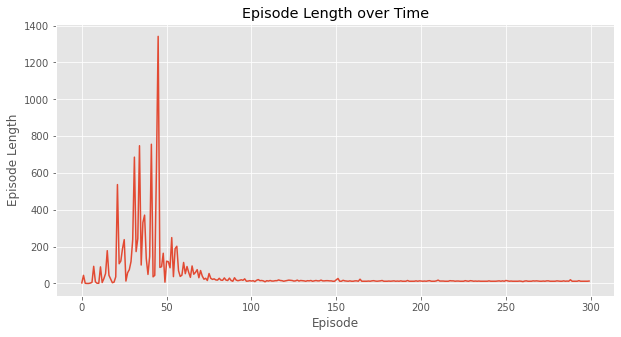

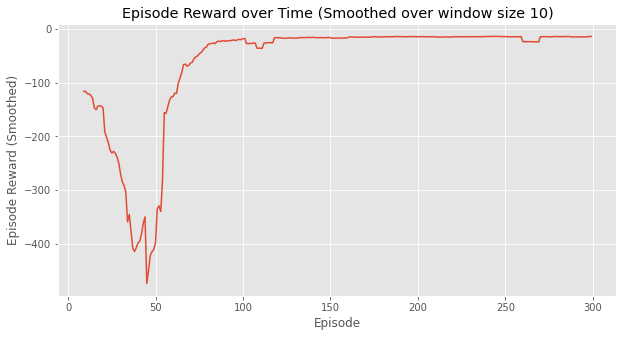

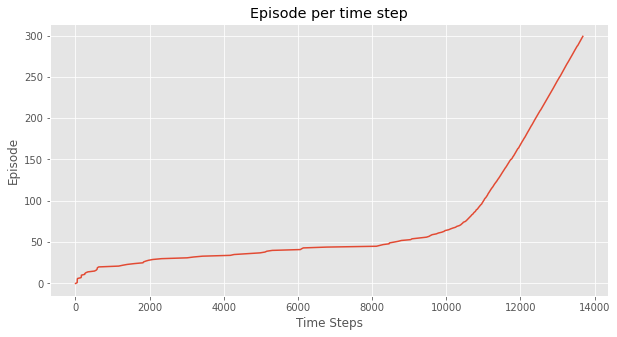

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [54]:
plots.plot_episode_stats(stats, smoothing_window=10)
